In [ ]:
#!pip install pysift
#To grader: If you want to run this on colab, make sure to get pysift.py uploaded.
from scipy import linalg
import random
import cv2 as cv
import pysift
import numpy as np
import scipy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import *


images = ['book.pgm', 'scene.pgm']
image_book = cv.imread(images[0], 0)
image_scene = cv.imread(images[1], 0)

kpb, deb = pysift.computeKeypointsAndDescriptors(image_book)
kps, des = pysift.computeKeypointsAndDescriptors(image_scene)

img_dispb=cv.drawKeypoints(image_book,kpb, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_disps=cv.drawKeypoints(image_scene,kps, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

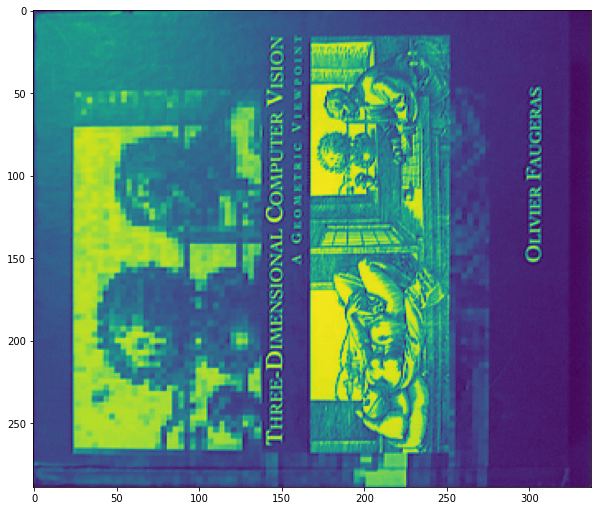

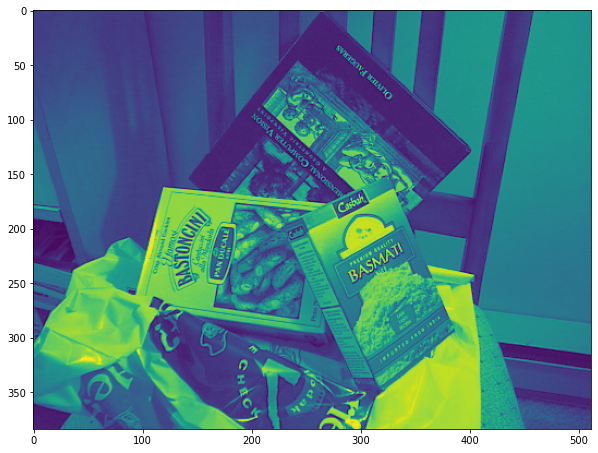

In [ ]:
def plot(image):
    plt.figure(figsize = (10,10))
    plt.imshow(image)

plot(image_book)
plot(image_scene)

In [ ]:
matchlines = []
bf = cv.BFMatcher()
matches = bf.knnMatch(deb, des, k=2)

threshold = 0.8
#append it to 
for x,y in matches:
    if x.distance < threshold *y.distance:
        matchlines.append(x)

matches = sorted(matchlines, key =lambda x:x.distance)
img = image_book
img = cv.drawMatches(image_book,kpb,image_scene,kps,matches[:10],img,flags=2)

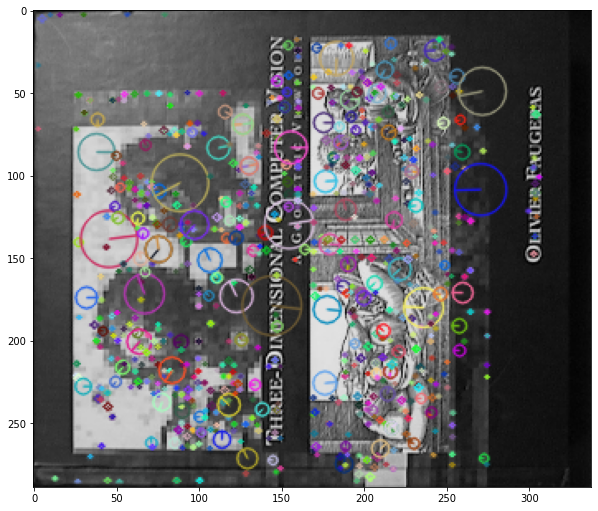

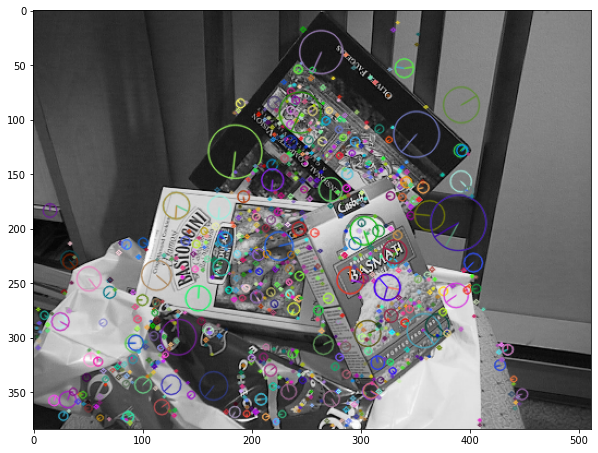

In [ ]:
book_plot = cv.drawKeypoints(image_book, kpb, outImage = None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot(book_plot)
scene_plot = cv.drawKeypoints(image_scene,kps,outImage = None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot(scene_plot)

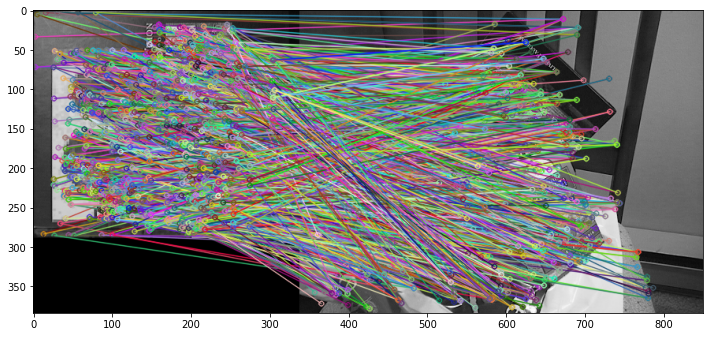

(0.0, 1.0, 0.0, 1.0)

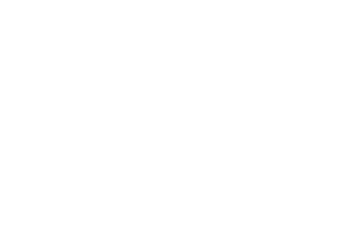

In [ ]:
def Matchline(img_disp1, kp1, des1, img_disp2, kp2, des2):
    matches = bf.knnMatch(queryDescriptors=des1,trainDescriptors=des2, k=2)
    img3 = cv.drawMatchesKnn(img_disp1,kp1,img_disp2,kp2,matches,None,flags=2)
    plt.figure(figsize=(12,15))
    plt.imshow(img3)
    plt.show()
    
Matchline(image_book,kpb,deb,image_scene, kps, des)
plt.axis('off')

(-0.5, 849.5, 383.5, -0.5)

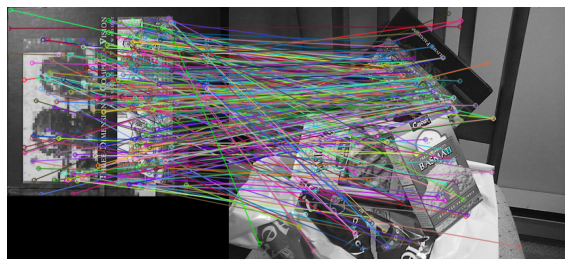

In [ ]:
matches = bf.knnMatch(queryDescriptors=deb,trainDescriptors=des, k=2)
good = []
good_without_list = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append([m])
        good_without_list.append(m)
matches_img = cv.drawMatchesKnn(image_book,kpb,image_scene,kps,good,flags=2,outImg=None)
plot(matches_img)
plt.axis('off')

max count: 114


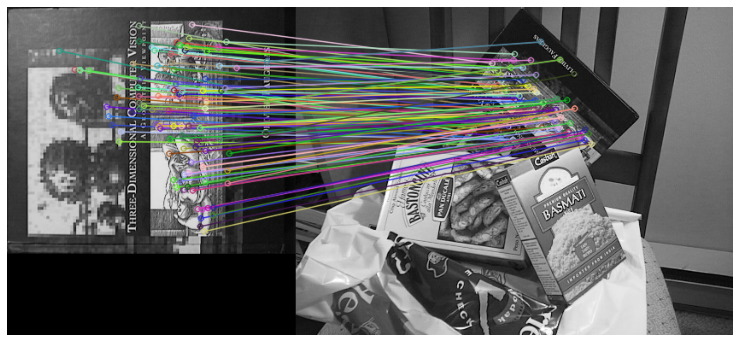

In [ ]:
src_pts = np.float32([kpb[m.queryIdx].pt for m in good_without_list])
dst_pts = np.float32([kps[m.trainIdx].pt for m in good_without_list])

N = 100

max_count = 0
best_inliers = 0
best_q = 0
for i in range(N):
    pick_matches = np.random.choice(range(len(src_pts)), 3)
    A = np.zeros([6,6])
    B = np.zeros([6])
    for j in range(3):
        A[2*j][0] = src_pts[pick_matches[j]][0]
        A[2*j][1] = src_pts[pick_matches[j]][1]
        A[2*j][2] = 1
        A[2*j+1][3] = src_pts[pick_matches[j]][0]
        A[2*j+1][4] = src_pts[pick_matches[j]][1]
        A[2*j+1][5] = 1
        B[2*j] = dst_pts[pick_matches[j]][0]
        B[2*j+1] = dst_pts[pick_matches[j]][1]
    try:
        q = np.linalg.solve(A, B)
    except:
        continue
        
    
    count = 0
    inliers = []
    for j in range(len(src_pts)):
        transform = np.dot(np.array([[src_pts[j][0],src_pts[j][1],1,0,0,0],[0,0,0,src_pts[j][0],src_pts[j][1],1]]),q)
        if np.linalg.norm(transform - dst_pts[j]) < 10:
            count += 1
            inliers.append(good_without_list[j])
    if count>max_count:
        max_count = count
        best_inliers = inliers
        best_q = q
print('max count:',max_count)

matches_img = cv.drawMatches(image_book,kpb,image_scene,kps,best_inliers,flags=2,outImg=None)
plt.figure(figsize = (13,13))
plt.imshow(matches_img,cmap='gist_gray');
plt.axis('off');

[]

<Figure size 432x288 with 0 Axes>

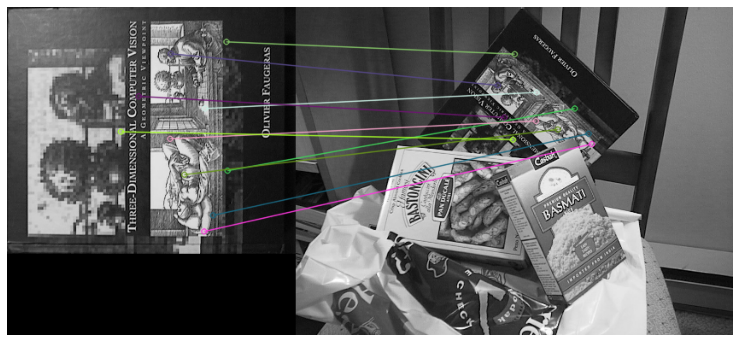

In [ ]:
fig = plt.figure()
plt.figure(figsize = (13,13))
plt.axis('off')
plt.imshow(img)
plt.plot()

(-0.5, 511.5, 383.5, -0.5)

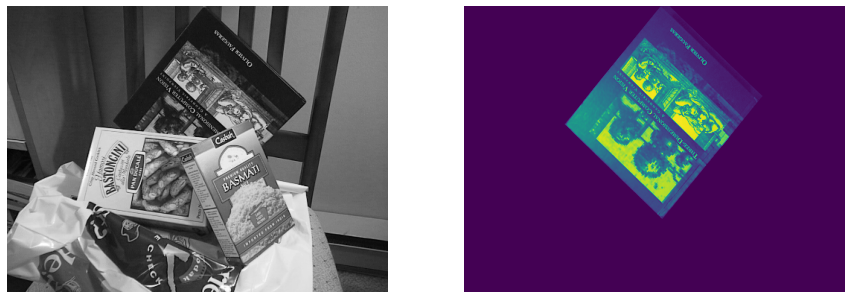

In [ ]:
H_matrix = np.zeros([3,3])
H_matrix[0][0] = best_q[0]
H_matrix[0][1] = best_q[1]
H_matrix[0][2] = best_q[4]
H_matrix[1][0] = best_q[2]
H_matrix[1][1] = best_q[3]
H_matrix[1][2] = best_q[5]
H_matrix[2][2] = 1
H_matrix = best_q.reshape(2,3)

pose = cv.warpAffine(image_book, H_matrix, (image_scene.shape[1], image_scene.shape[0]))
#plt.imshow(pose)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[1].imshow(pose)
axs[1].axis('off')
axs[0].imshow(image_scene,cmap='gist_gray')
axs[0].axis('off')

In [ ]:
def Hmatrix(H):
    return np.append(H, np.ones((H.shape[0],H.shape[1],1)),axis=2)


#process data
candidates = np.array(match_candidates)
src = np.array([kpb[match.queryIdx].pt for match in candidates])
src = src.reshape(-1,1,2)
src = Hmatrix(src)
#dataset
dst = np.array([kps[match.trainIdx].pt for match in candidates])
dst = dst.reshape(-1,1,2)
dst = Hmatrix(dst)
data = []
for i in range(len(src)):
    data.append([src[i],dst[i]])
best_cnt = 0
sz = len(data)

#inliers
for round in range(100):
    inliers = []

    idx = random.sample(data,3)
    A = np.zeros((1,6))
    tvec = np.zeros((1,1))
    for i in range(3):
        A = np.append(A, np.append(idx[i][0],np.zeros((1,3)),axis =1),axis = 0)
        A = np.append(A, np.append(np.zeros((1,3)),idx[i][0],axis=1),axis = 0)
        tvec = np.append(tvec, idx[i][1].reshape((3,1))[:-1],axis=0)
    A = A[1:,:]
    tvec = tvec[1:,:]
    try:
        solution = np.linalg.solve(A,tvec)
    except:
        continue
    for i in range(sz):
        x = solution.reshape((2,3)).dot(data[i][0].T).reshape((1,2))
        y = np.delete(data[i][1],2,axis=1).reshape((1,2))
        if np.linalg.norm(x-y)<10:
            inliers.append(i)
    if len(inliers) > best_cnt:
        best_inliers = inliers
        best_cnt = len(inliers)
        best_solution = solution
        
print('inliers:\n', best_cnt)
best_solution = best_solution.reshape((2,3))
print('RANSAC value is:\n', best_solution)
homography, mask = cv.findHomography(src,dst,cv.RANSAC,ransacReprojThreshold =2.0)
print('Homography Matrix:\n',homography)


pose = cv.warpAffine(image_book, best_solution.reshape((2,3)),(image_scene.shape[1], image_scene.shape[0]))

sz = len(best_inliers)
A = np.zeros((1,6))
tvec = np.zeros((1,1))
idx = data 

for p in range(sz):
    i = best_inliers[p]
    A = np.append(A, np.append(idx[i][0], np.zeros((1,3)), axis=1), axis = 0)
    A = np.append(A, np.append(np.zeros((1,3)), idx[i][0], axis =1), axis = 0)
    tvec = np.append(tvec, idx[i][1].reshape((3,1))[:-1],axis=0)
A = A[1:, :]
tvec = tvec[1:, :]
refit_solution = (np.linalg.lstsq(A,tvec,rcond=None)[0])

print('refit_solution:\n', refit_solution.reshape((2,3)))
pose = cv.warpAffine(image_book, refit_solution.reshape((2,3)),(image_scene.shape[1], image_scene.shape[0]))


inliers:
 109
RANSAC value is:
 [[  0.38418662   0.4523256  138.77915484]
 [ -0.48327633   0.41748411 161.7178536 ]]
Homography Matrix:
 [[ 2.90240357e-01  4.45145063e-01  1.41707637e+02]
 [-4.66800005e-01  3.97871861e-01  1.53512503e+02]
 [-3.42747238e-04  7.23351591e-05  1.00000000e+00]]
refit_solution:
 [[  0.40077908   0.4522761  135.13846632]
 [ -0.45571729   0.41782549 155.4069019 ]]
